<a href="https://colab.research.google.com/github/sdalal1/Visual-Odometry/blob/main/Visual_Odometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import progressbar

In [2]:
file_path = '../dataset/sequences/00/image_0/'
left_images = os.listdir(file_path) # list of strings with names of images
print(len(left_images))

4541


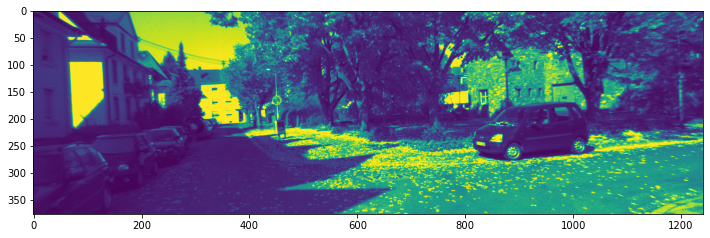

In [3]:
plt.figure(figsize=(12, 4))
plt.imshow(cv2.imread(file_path + left_images[0], 0))

In [15]:
calib = pd.read_csv('../dataset/sequences/00/calib.txt', delimiter=" ", header=None, index_col=0)
Tr = np.array(calib.iloc[3]).reshape((3, 4))
print(Tr.round(3))

[[ 7.18856e+02  0.00000e+00  6.07193e+02 -3.37288e+02]
 [ 0.00000e+00  7.18856e+02  1.85216e+02  2.36900e+00]
 [ 0.00000e+00  0.00000e+00  1.00000e+00  5.00000e-03]]


In [ ]:
def Dataset_Handler():

    def __init__(self, sequence, lidar=False, progressbar=True, low_memory=True):

        self.lidar = lidar
        self.low_memory = low_memory

        self.seq_dir = f"../dataset/sequences/{sequence}/"
        self.poses_dir = f"../dataset/sequences/{sequence}.txt"

        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        self.num_frames = len(self.left_image_files)

        poses = pd.read_csv(self.poses_dir, delimiter=" ", header=None)
        self.gt = np.zeros(self.num_frames, 3, 4)

        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))

        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=" ", header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0: ']).reshape((3, 4))
        self.P1 = np.array(cali.loc['P1: ']).reshape((3, 4))
        self.P2 = np.array(calib.loc['P2: ']).reshape((3, 4))
        self.P3 = np.array(calib.loc['P3: ']).reshape((3, 4))
        self.Tr = np.array(calib.loc['Tr: ']).reshape((3, 4))

        if low_memory:
            self.reset_frames
            self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' + 
                                               self.left_image_files[0], 0)
            self.first_image_right = cv2.imread(self.seq_dir + 'image_0/' + 
                                               self.right_image_files[0], 0)
            self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' + 
                                               self.left_image_files[1], 0)
        else:
            if progress_bar:
                bar = progressbar.ProgressBar(maxval=self.num_frames)
            for i, name_left in enumerate(self.left_image_files):
                name_right = sefl.right_image_files[i]
                self.images_left.append(cv2.imread(self.seq_dir + 'image_0/' + name_left))
                self.images_right.append(cv2.imread(self.seq_dir + 'image_1/' + name_right))

    def reset_frames(self):
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right= (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.left_image_files)

In [ ]:
test_gen = (i for i in range(5))

In [ ]:
next(test_gen)